# Brain Tumor Detection by using MRI Images🧠🩺

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization, MaxPooling2D,Dropout,Flatten,Dense, Activation
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

sns.set_style('darkgrid')
%matplotlib inline
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

RANDOM_SEED = 101


## Dataset

- `NO` - no tumor, encoded as `0`
- `YES` - tumor, encoded as `1`

 Right now all images are in one folder with yes and no subfolders. I will split the data into train, val and test folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [2]:
IMG_PATH = 'brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'NORMAL/TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n<0.8*IMG_NUM:
                shutil.copy(img, 'NORMAL/TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'NORMAL/VAL/' + CLASS.upper() + '/' + FILE_NAME)

## Data import and Preprocessing

In [3]:
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i=0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

## Data Loading

In [4]:
TRAIN_DIR = 'NORMAL/TRAIN/'
TEST_DIR = 'NORMAL/TEST/'
VAL_DIR = 'NORMAL/VAL/'
IMG_SIZE = (180,180)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _  = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


193 images loaded from NORMAL/TRAIN/ directory.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 181.09it/s]


10 images loaded from NORMAL/TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.47it/s]

50 images loaded from NORMAL/VAL/ directory.


## Distribution of classes among sets:

In [5]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name==0))
    y[1].append(np.sum(set_name==1))
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title':'Set'},
    yaxis={'title':'Count'}
)
fig = go.Figure(data,layout)
iplot(fig)

## Plot samples

In [6]:
def plot_samples(X,y,labels_dict, n=50):
    """
        Create a gridplot for desired number of images (n) from specified set
    """ 
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y==index)][:n]
        j = 10
        i = int(n/j)
        
        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0].astype("uint8"))
            
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

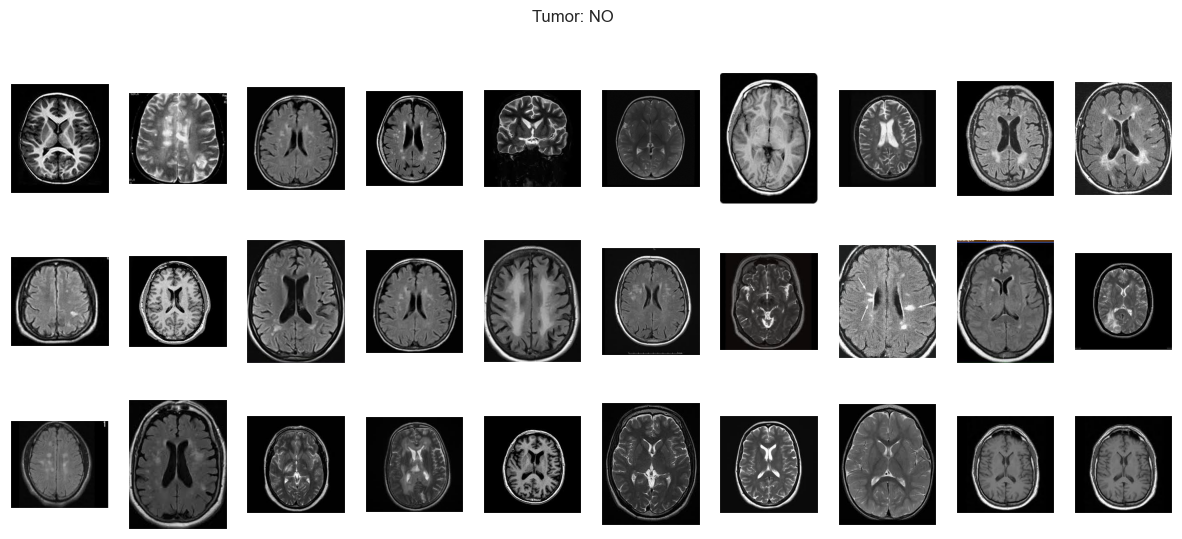

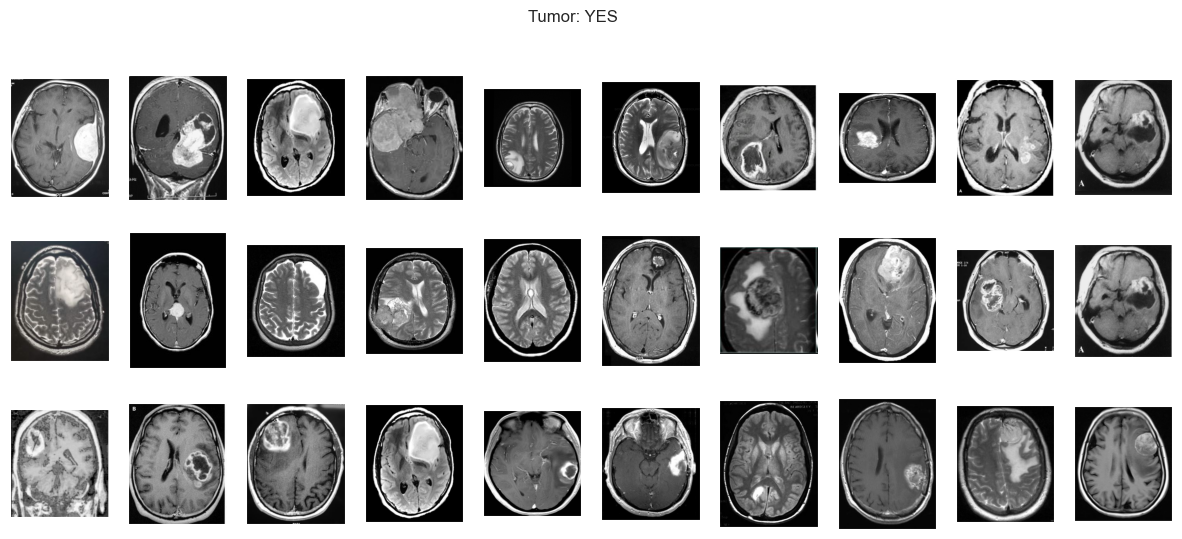

In [7]:
plot_samples(X_train, y_train, labels, 30)

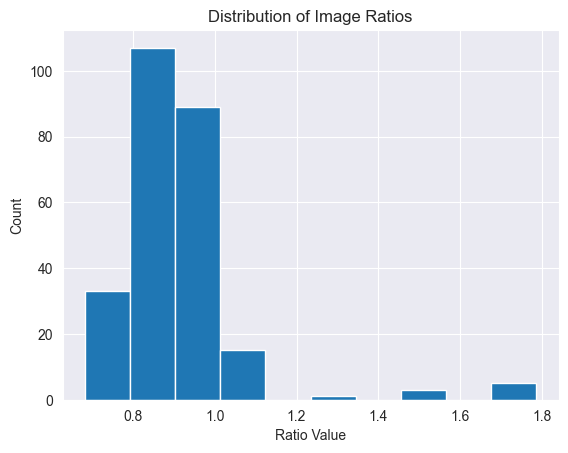

In [8]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images.

`Erosion is an operation that erodes away the boundaries of foreground objects. It is performed by applying a structuring element (kernel) to the image and replacing the central pixel of the kernel with the minimum value of the pixels under the kernel. This reduces the size of the foreground objects and eliminates small white pixels (noise) from the image.

Dilation is the opposite of erosion. It expands the boundaries of the foreground objects by replacing the central pixel of the kernel with the maximum value of the pixels under the kernel. This increases the size of the foreground objects and fills small holes in the objects.`

In [9]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [10]:
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

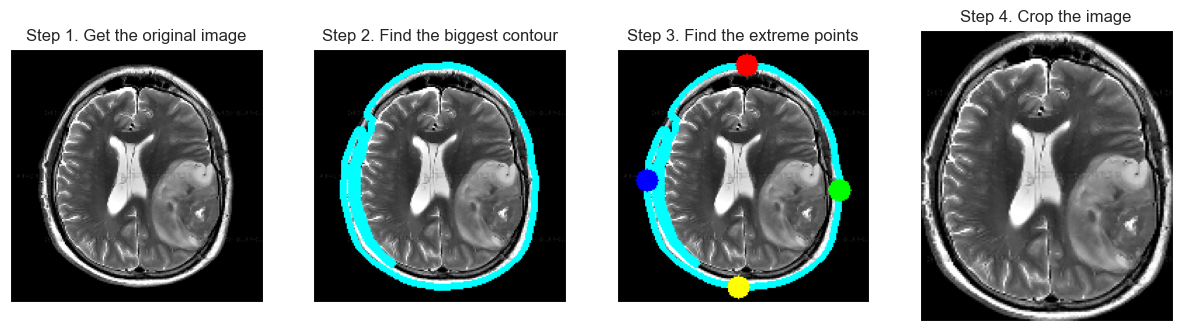

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')

plt.show();

In [12]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

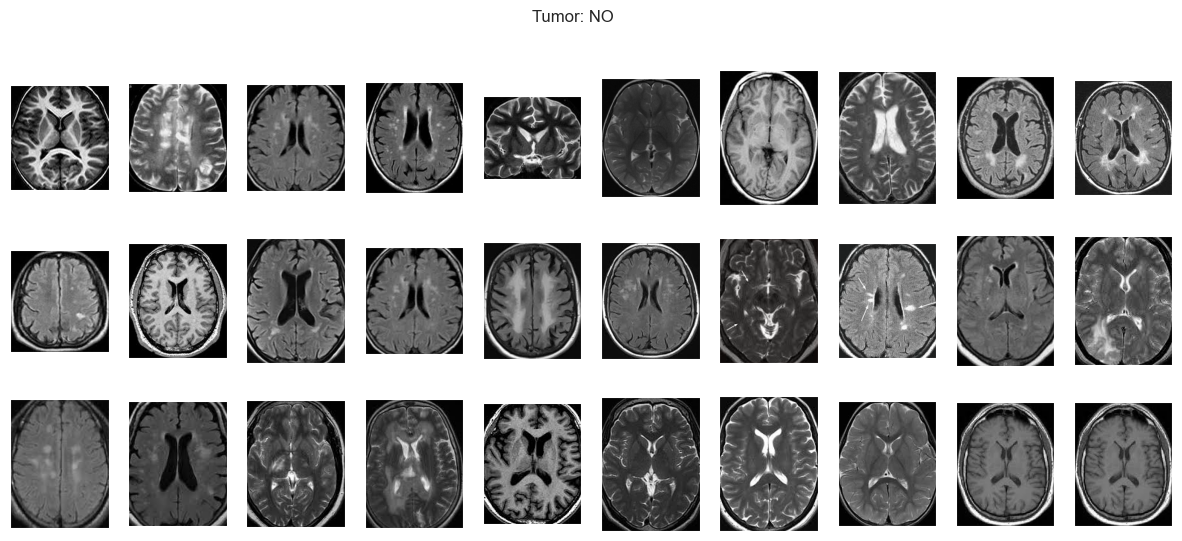

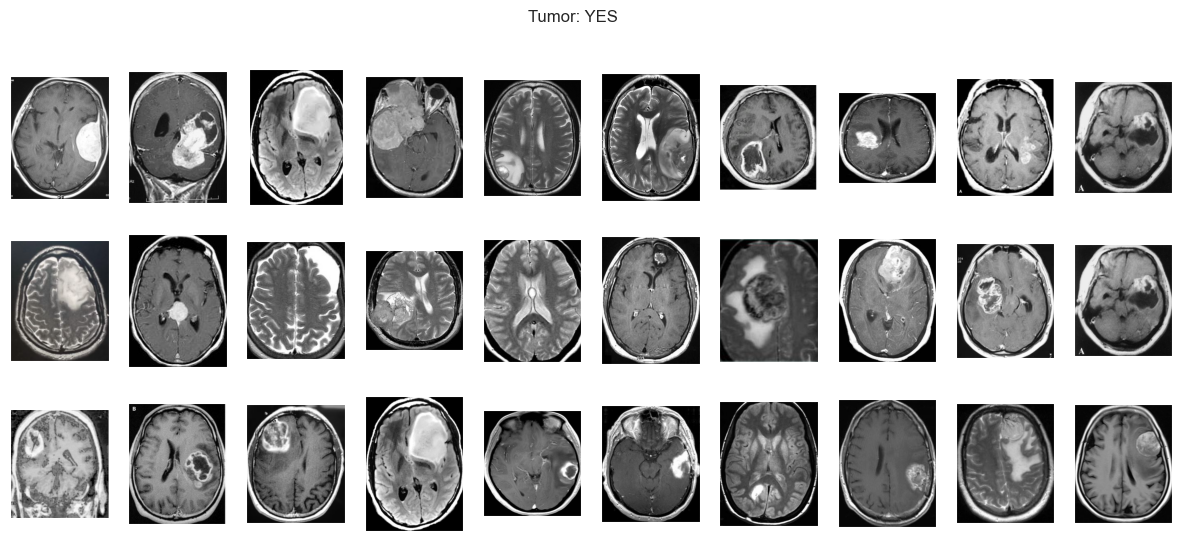

In [13]:
plot_samples(X_train_crop, y_train, labels, 30)

In [14]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [15]:
save_new_images(X_train_crop, y_train, folder_name='CROPPED/TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='CROPPED/VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='CROPPED/TEST_CROP/')

The next step would be resizing images to (224,224) and applying preprocessing needed for VGG-16 model input

In [16]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [17]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [18]:
train_x = np.array(X_train_prep)
test_x = np.array(X_test_prep)
val_x = np.array(X_val_prep)

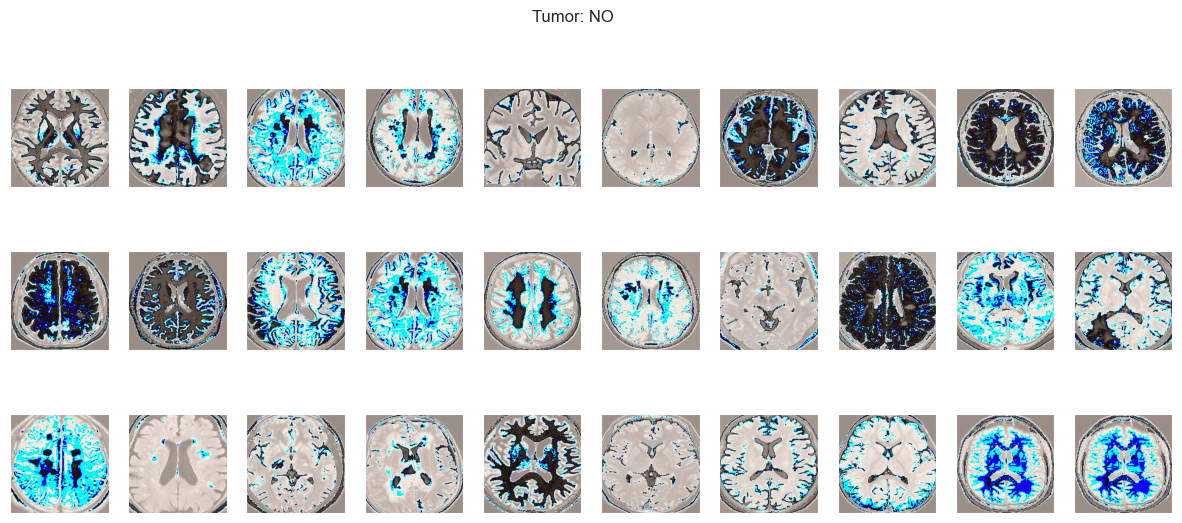

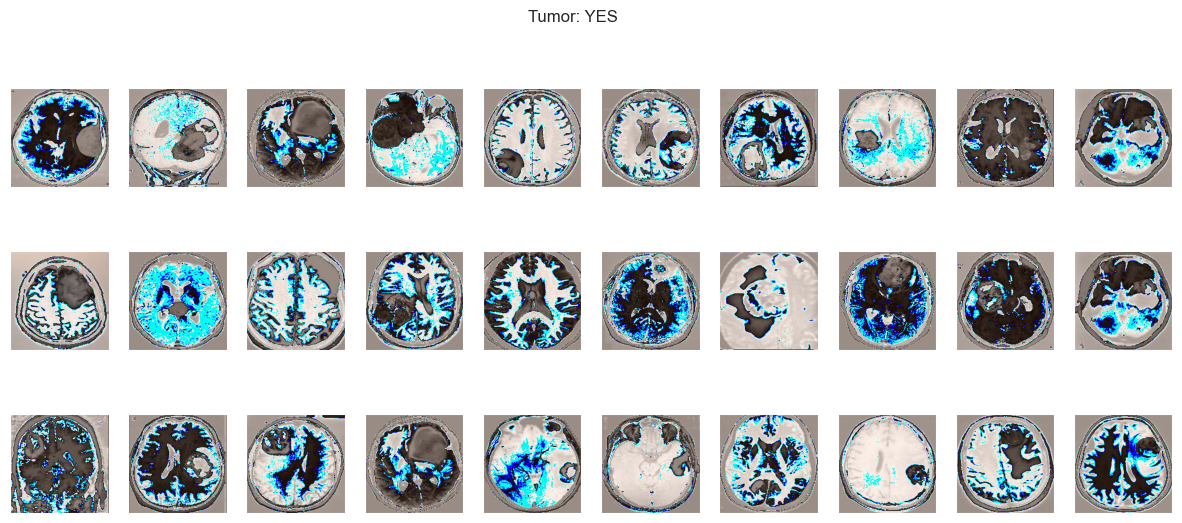

In [19]:
plot_samples(X_train_prep,y_train,labels,30)

In [20]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = accuracy_score(y_true, y_pred)
    
    return score

# Pre-preocssing the data for CNN

## Data Augmentation

In [21]:
demo_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    rescale = 1./255,
    shear_range = 0.05,
    brightness_range = [0.1,1.5],
    horizontal_flip = True,
    vertical_flip = True
)

In [22]:
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

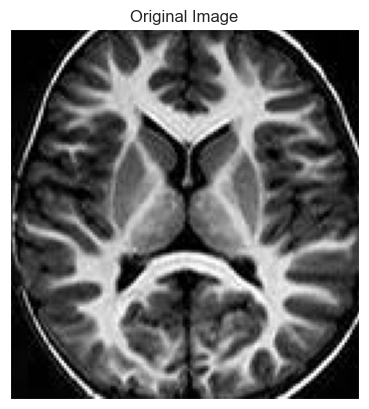

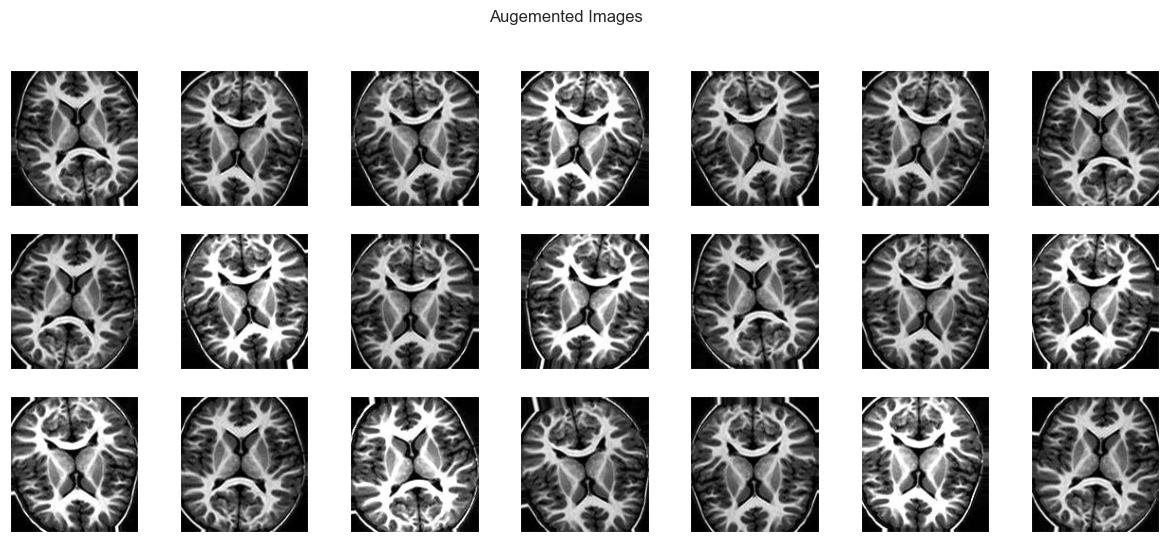

In [23]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.show()

plt.figure(figsize=(15,6))
i=1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/'+ img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i>3*7:
        break
plt.suptitle('Augemented Images')
plt.show()
    

In [24]:
IMG_SIZE

(180, 180)

In [25]:
TRAIN_DIR = 'CROPPED/TRAIN_CROP_AUG/'
VAL_DIR = 'CROPPED/VAL_CROP_AUG/'
TEST_DIR = 'CROPPED/TEST_CROP_AUG/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size = IMG_SIZE,
    class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 701 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


In [26]:
train_X, train_y = next(train_generator)
test_X, test_y = next(test_generator)
val_X, val_y = next(validation_generator)

In [30]:
base_model = tf.keras.applications.VGG16(weights='imagenet',
                                              include_top=False,
                                              input_shape = IMG_SIZE + (3,)
                                              )

In [31]:
model = Sequential()
model.add(base_model)
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 dense (Dense)               (None, 5, 5, 512)         262656    
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 dense_1 (Dense)             (None, 5, 5, 512)         262656    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                        

In [32]:
EPOCHS = 20
batch_size = 32

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=int(701/batch_size), 
    validation_steps=int(147/batch_size)
)

Epoch 1/20
21/21 [==============================] - 9s 235ms/step - loss: 2.9699 - accuracy: 0.6233 - val_loss: 0.4325 - val_accuracy: 0.8516
Epoch 2/20
21/21 [==============================] - 4s 185ms/step - loss: 0.6710 - accuracy: 0.7743 - val_loss: 0.2572 - val_accuracy: 0.8984
Epoch 3/20
21/21 [==============================] - 4s 188ms/step - loss: 0.4688 - accuracy: 0.8102 - val_loss: 0.2316 - val_accuracy: 0.9297
Epoch 4/20
21/21 [==============================] - 4s 178ms/step - loss: 0.4966 - accuracy: 0.8401 - val_loss: 0.2366 - val_accuracy: 0.9219
Epoch 5/20
21/21 [==============================] - 4s 181ms/step - loss: 0.3339 - accuracy: 0.8670 - val_loss: 0.2225 - val_accuracy: 0.8906
Epoch 6/20
21/21 [==============================] - 4s 173ms/step - loss: 0.2540 - accuracy: 0.8894 - val_loss: 0.2262 - val_accuracy: 0.8984
Epoch 7/20
21/21 [==============================] - 4s 180ms/step - loss: 0.2245 - accuracy: 0.9028 - val_loss: 0.1833 - val_accuracy: 0.9375
Epoch 

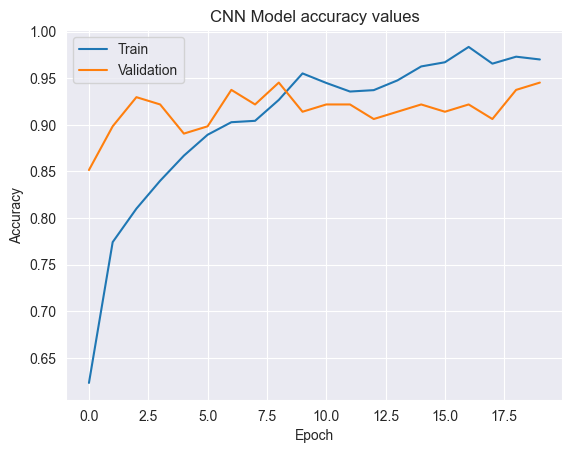

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

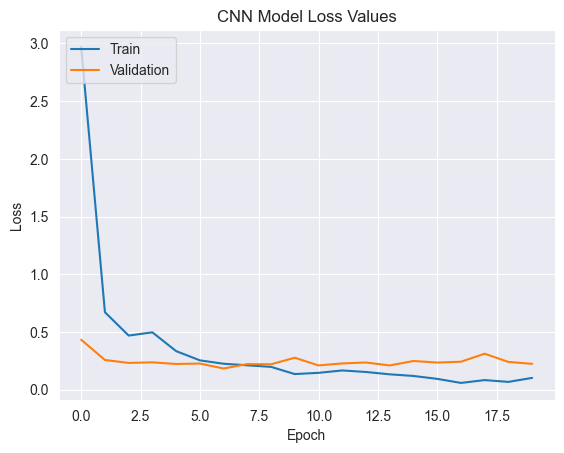

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss Values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Saving the Model

In [59]:
model.save('best_models/brain_tumor_aug')

INFO:tensorflow:Assets written to: best_models/brain_tumor_aug\assets


# Load the model

Experimenting with the Best Model ( The one with the best validation accuracy )

In [37]:
from keras.models import load_model
best_model = load_model(filepath='best_models/brain_tumor_aug')

In [38]:
best_model.metrics_names

['loss', 'accuracy']

## BenchMark Tests on VGG16 Trained Model

In [39]:
loss , accuracy = best_model.evaluate(test_X,test_y)

1/1 [==============================] - 0s 208ms/step - loss: 0.0734 - accuracy: 0.9688


### Accuracy of the model on the testing data:

In [40]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.07342173159122467
Test Accuracy = 0.96875


### F1 score for the model on the testing data and validation data:

In [41]:
y_test_prob = best_model.predict(test_X)
y_test_prob

array([[9.9838126e-01],
       [9.9993157e-01],
       [8.8511984e-04],
       [9.9998593e-01],
       [9.9065085e-04],
       [3.2905642e-02],
       [9.9606186e-01],
       [9.9999988e-01],
       [1.0000000e+00],
       [2.0417515e-02],
       [1.7928706e-01],
       [9.9983466e-01],
       [7.2508141e-05],
       [9.9029386e-01],
       [5.6519867e-03],
       [5.4221618e-01],
       [9.9999857e-01],
       [2.4296092e-05],
       [9.9984348e-01],
       [9.9980706e-01],
       [1.1959630e-04],
       [9.9780518e-01],
       [1.4472998e-03],
       [7.8909546e-01],
       [6.4045316e-01],
       [1.5114961e-02],
       [4.1463059e-06],
       [9.7574812e-01],
       [9.9887735e-01],
       [8.5629243e-01],
       [6.2163570e-04],
       [9.9804461e-01]], dtype=float32)

In [42]:
f1score = compute_f1_score(test_y, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.96875


Let's also find the f1 score on the validation data:

In [43]:
y_val_prob = best_model.predict(val_X)
y_val_prob

array([[2.7499175e-01],
       [9.9596930e-01],
       [9.6436340e-04],
       [5.9772265e-01],
       [6.5190125e-01],
       [9.9999964e-01],
       [9.9995744e-01],
       [1.0000000e+00],
       [5.8631981e-03],
       [9.9999988e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9994326e-01],
       [9.9974984e-01],
       [1.9225977e-02],
       [7.5940335e-01],
       [3.3266135e-04],
       [1.2211779e-03],
       [9.9776685e-01],
       [9.7984409e-01],
       [9.2421687e-01],
       [9.9874133e-01],
       [2.5418806e-01],
       [1.0000000e+00],
       [7.6976806e-02],
       [9.9919802e-01],
       [5.9226364e-02],
       [9.9818486e-01],
       [9.9997830e-01],
       [9.8435289e-01],
       [8.2179077e-02],
       [9.8765832e-01]], dtype=float32)

In [44]:
f1score_val = compute_f1_score(val_y, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.90625


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_y, y_val_prob.round()))

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84         9
         1.0       0.95      0.91      0.93        23

    accuracy                           0.91        32
   macro avg       0.88      0.90      0.89        32
weighted avg       0.91      0.91      0.91        32



In [46]:
cm = confusion_matrix(val_y, y_val_prob.round())
cm

array([[ 8,  1],
       [ 2, 21]], dtype=int64)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf, group_names=None, categories='auto', count=True,
                          percent=True, cbar=True, xyticks=True, xyplotlabels=True,
                          sum_stats=True, figsize=None, cmap='Blues', title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Confusion Matrix of Validation Data(VGG 16)

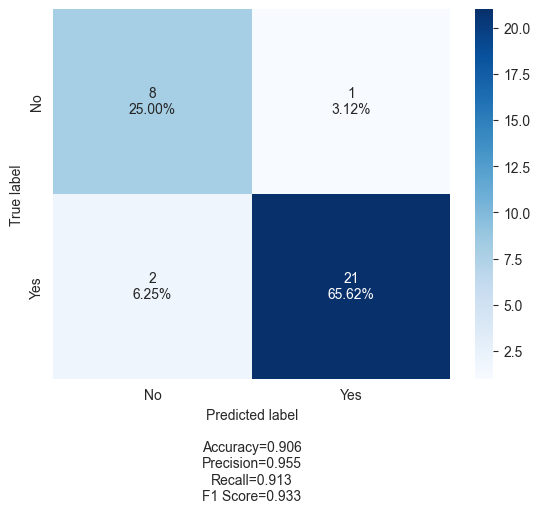

In [48]:
categories = ['No','Yes']
make_confusion_matrix(cm, categories=categories)

In [49]:
print(classification_report(test_y, y_test_prob.round()))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        14
         1.0       0.95      1.00      0.97        18

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



In [50]:
cm = confusion_matrix(test_y, y_test_prob.round())
cm

array([[13,  1],
       [ 0, 18]], dtype=int64)

### Confusion Matrix of Test Data(VGG 16)

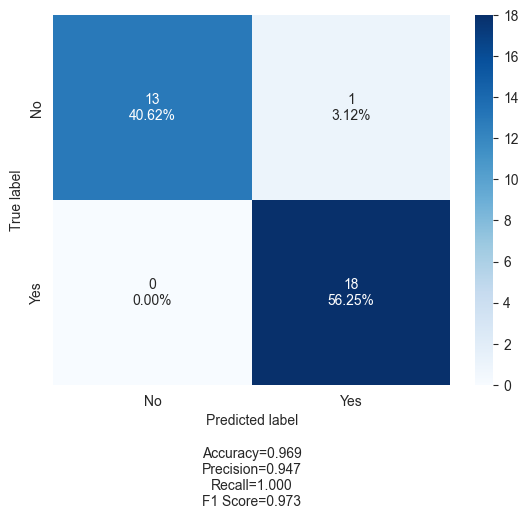

In [51]:
categories = ['No','Yes']
make_confusion_matrix(cm, categories=categories)

In [52]:
base_model_1 = tf.keras.applications.resnet50.ResNet50(weights='imagenet',
                                              include_top=False,
                                              input_shape = IMG_SIZE + (3,)
                                              )

In [53]:
model_1 = Sequential()
model_1.add(base_model_1)
model_1.add(Dense(units=512, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(units=512, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(tf.keras.layers.GlobalAveragePooling2D())
model_1.add(Flatten())
model_1.add(Dropout(0.5))
model_1.add(Dense(1,activation='sigmoid'))

model_1.layers[0].trainable = False

model_1.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dense_3 (Dense)             (None, 6, 6, 512)         1049088   
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 512)         0         
                                                                 
 dense_4 (Dense)             (None, 6, 6, 512)         262656    
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 512)         0         
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                      

In [54]:
EPOCHS = 20
batch_size = 32

history_1 = model_1.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=int(701/batch_size), 
    validation_steps=int(147/batch_size)
)

Epoch 1/20
21/21 [==============================] - 7s 240ms/step - loss: 1.0620 - accuracy: 0.5949 - val_loss: 0.3906 - val_accuracy: 0.9375
Epoch 2/20
21/21 [==============================] - 4s 185ms/step - loss: 0.3768 - accuracy: 0.8356 - val_loss: 0.2086 - val_accuracy: 0.9609
Epoch 3/20
21/21 [==============================] - 4s 183ms/step - loss: 0.3397 - accuracy: 0.8520 - val_loss: 0.2382 - val_accuracy: 0.9375
Epoch 4/20
21/21 [==============================] - 4s 186ms/step - loss: 0.2660 - accuracy: 0.8864 - val_loss: 0.1624 - val_accuracy: 0.9141
Epoch 5/20
21/21 [==============================] - 4s 183ms/step - loss: 0.1953 - accuracy: 0.9223 - val_loss: 0.2243 - val_accuracy: 0.9062
Epoch 6/20
21/21 [==============================] - 4s 189ms/step - loss: 0.1942 - accuracy: 0.9268 - val_loss: 0.1950 - val_accuracy: 0.9062
Epoch 7/20
21/21 [==============================] - 4s 186ms/step - loss: 0.1181 - accuracy: 0.9567 - val_loss: 0.2313 - val_accuracy: 0.8828
Epoch 

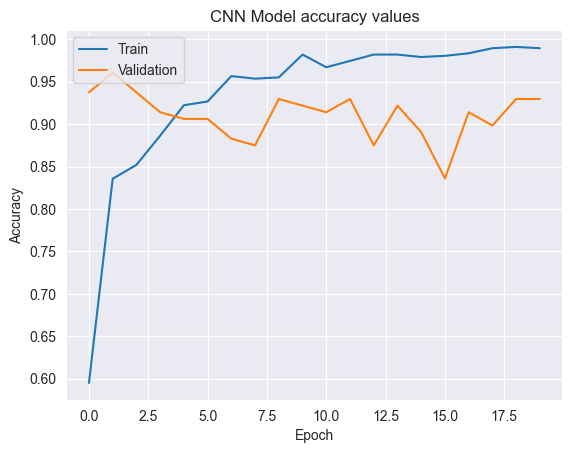

In [55]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

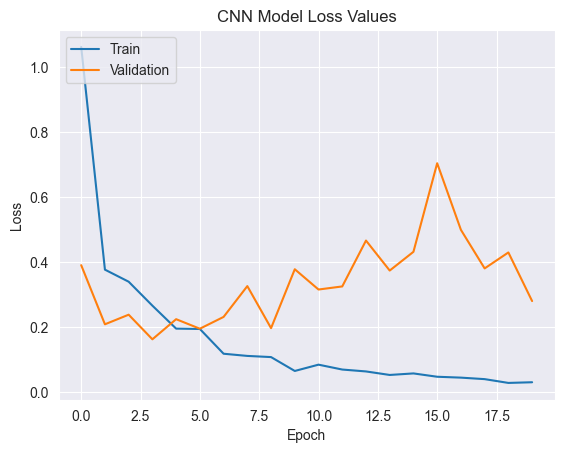

In [56]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('CNN Model Loss Values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [58]:
model_1.save('best_models/brain_tumor_resnet')

INFO:tensorflow:Assets written to: best_models/brain_tumor_resnet\assets


In [60]:
model_1 = load_model(filepath='best_models/brain_tumor_resnet')

## BenchMark Tests on Resnet-50

In [61]:
loss , accuracy = model_1.evaluate(test_X,test_y)

1/1 [==============================] - 1s 631ms/step - loss: 0.0120 - accuracy: 1.0000


In [62]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.01197793334722519
Test Accuracy = 1.0


In [63]:
y_test_prob = model_1.predict(test_X)
y_test_prob

array([[1.0000000e+00],
       [1.0000000e+00],
       [2.3291701e-02],
       [9.9999952e-01],
       [1.5547144e-02],
       [1.3474225e-03],
       [8.9405662e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [6.3537230e-04],
       [3.5260749e-04],
       [9.9242049e-01],
       [1.6982079e-07],
       [9.9999964e-01],
       [1.2404306e-02],
       [9.9999964e-01],
       [9.9958414e-01],
       [1.3707951e-06],
       [1.0000000e+00],
       [9.9999881e-01],
       [8.8730769e-04],
       [9.9922764e-01],
       [6.5811710e-03],
       [9.9999905e-01],
       [9.1095725e-03],
       [1.6237804e-01],
       [2.5274501e-06],
       [9.9999750e-01],
       [9.9999940e-01],
       [9.9945098e-01],
       [1.3961618e-02],
       [9.9999416e-01]], dtype=float32)

In [64]:
f1score = compute_f1_score(test_y, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 1.0


In [65]:
y_val_prob = model_1.predict(val_X)
y_val_prob

array([[9.9998283e-01],
       [1.0000000e+00],
       [3.2977718e-03],
       [9.9992025e-01],
       [9.9713767e-01],
       [9.9996936e-01],
       [9.9999905e-01],
       [1.0000000e+00],
       [4.4050412e-03],
       [1.0000000e+00],
       [9.9999976e-01],
       [9.9999988e-01],
       [9.9999988e-01],
       [9.9999917e-01],
       [8.0353273e-03],
       [9.9998462e-01],
       [3.1355888e-05],
       [3.5644392e-03],
       [1.0000000e+00],
       [9.9973315e-01],
       [9.9999988e-01],
       [9.9999988e-01],
       [2.1423501e-01],
       [1.0000000e+00],
       [8.8455302e-01],
       [9.9638355e-01],
       [9.9202842e-01],
       [9.9999022e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [3.7510783e-06],
       [9.9983442e-01]], dtype=float32)

In [66]:
f1score_val = compute_f1_score(val_y, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.875


In [67]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_y, y_val_prob.round()))

              precision    recall  f1-score   support

         0.0       0.86      0.67      0.75         9
         1.0       0.88      0.96      0.92        23

    accuracy                           0.88        32
   macro avg       0.87      0.81      0.83        32
weighted avg       0.87      0.88      0.87        32



In [68]:
cm = confusion_matrix(val_y, y_val_prob.round())
cm

array([[ 6,  3],
       [ 1, 22]], dtype=int64)

### Confusion Matrix on Validation Data(Resnet-50)

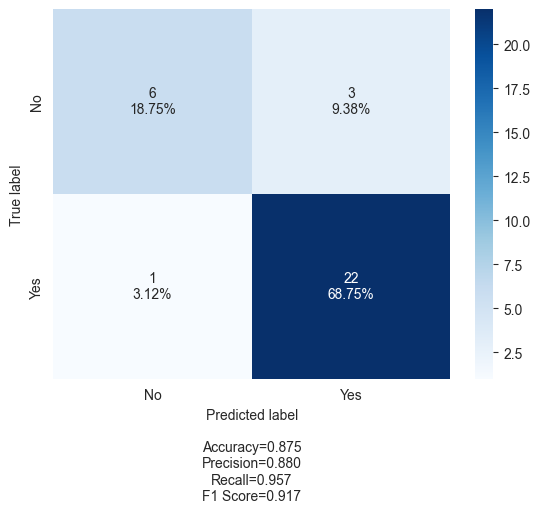

In [69]:
categories = ['No','Yes']
make_confusion_matrix(cm, categories=categories)

In [70]:
print(classification_report(test_y, y_test_prob.round()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00        18

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [71]:
cm = confusion_matrix(test_y, y_test_prob.round())
cm

array([[14,  0],
       [ 0, 18]], dtype=int64)

### Confusion Matrix on Test Data(Resnet-50)

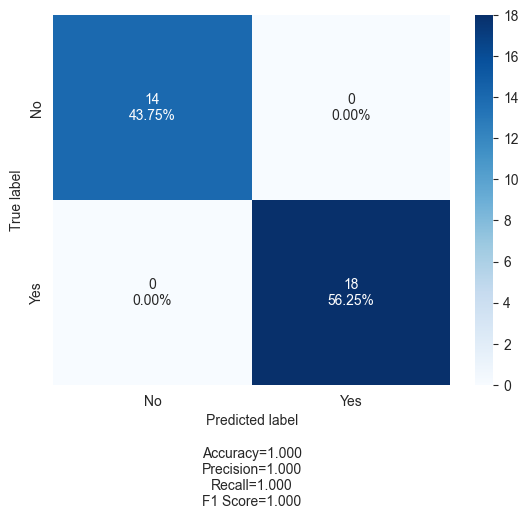

In [72]:
categories = ['No','Yes']
make_confusion_matrix(cm, categories=categories)

In [74]:
base_model_2 = tf.keras.applications.Xception(weights='imagenet',
                                              include_top=False,
                                              input_shape = IMG_SIZE + (3,)
                                              )

83697664/83683744 [==============================] - 9s 0us/step


In [75]:
model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(Dense(units=512, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(units=512, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(tf.keras.layers.GlobalAveragePooling2D())
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(1,activation='sigmoid'))

model_2.layers[0].trainable = False

model_2.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 dense_6 (Dense)             (None, 6, 6, 512)         1049088   
                                                                 
 dropout_6 (Dropout)         (None, 6, 6, 512)         0         
                                                                 
 dense_7 (Dense)             (None, 6, 6, 512)         262656    
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 512)         0         
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                      

In [76]:
EPOCHS = 20
batch_size = 32

history_2 = model_2.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=int(701/batch_size), 
    validation_steps=int(147/batch_size)
)

Epoch 1/20
21/21 [==============================] - 7s 223ms/step - loss: 2.6806 - accuracy: 0.5187 - val_loss: 0.7175 - val_accuracy: 0.6328
Epoch 2/20
21/21 [==============================] - 4s 178ms/step - loss: 0.8884 - accuracy: 0.5949 - val_loss: 0.6153 - val_accuracy: 0.6641
Epoch 3/20
21/21 [==============================] - 4s 184ms/step - loss: 0.7342 - accuracy: 0.6338 - val_loss: 0.5484 - val_accuracy: 0.6797
Epoch 4/20
21/21 [==============================] - 4s 178ms/step - loss: 0.5960 - accuracy: 0.6846 - val_loss: 0.5492 - val_accuracy: 0.7344
Epoch 5/20
21/21 [==============================] - 4s 178ms/step - loss: 0.6069 - accuracy: 0.6906 - val_loss: 0.5345 - val_accuracy: 0.6719
Epoch 6/20
21/21 [==============================] - 4s 182ms/step - loss: 0.5656 - accuracy: 0.6951 - val_loss: 0.6046 - val_accuracy: 0.6719
Epoch 7/20
21/21 [==============================] - 4s 183ms/step - loss: 0.5702 - accuracy: 0.7113 - val_loss: 0.4825 - val_accuracy: 0.7812
Epoch 

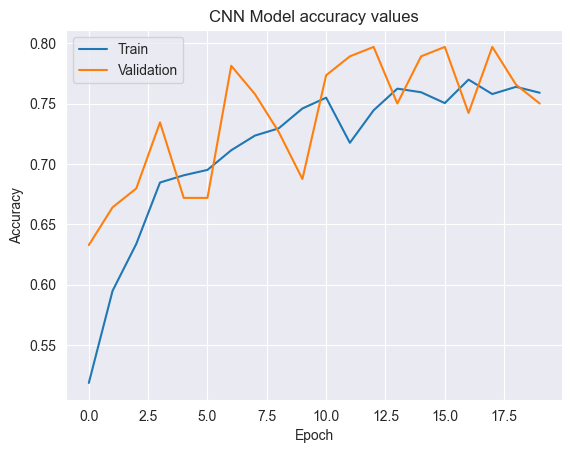

In [77]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

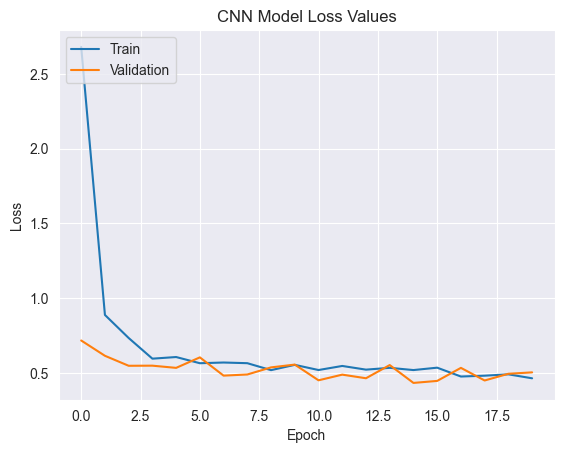

In [78]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('CNN Model Loss Values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [79]:
model_2.save('best_models/brain_tumor_xception')

INFO:tensorflow:Assets written to: best_models/brain_tumor_xception\assets


## BenchMark Tests on Xception

In [80]:
loss , accuracy = model_2.evaluate(test_X,test_y)

1/1 [==============================] - 1s 507ms/step - loss: 0.3198 - accuracy: 0.9062


In [81]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.31975728273391724
Test Accuracy = 0.90625


In [82]:
y_test_prob = model_2.predict(test_X)
y_test_prob

array([[0.7097283 ],
       [0.8983226 ],
       [0.5651344 ],
       [0.89794177],
       [0.17556654],
       [0.23542133],
       [0.7259862 ],
       [0.95477456],
       [0.98191375],
       [0.07903917],
       [0.27826735],
       [0.8011306 ],
       [0.36990175],
       [0.88810384],
       [0.20770136],
       [0.616451  ],
       [0.7516084 ],
       [0.24318816],
       [0.9158985 ],
       [0.5713157 ],
       [0.00410801],
       [0.644416  ],
       [0.11174145],
       [0.89271253],
       [0.5394512 ],
       [0.3588166 ],
       [0.41048026],
       [0.5205421 ],
       [0.79385996],
       [0.42551267],
       [0.18849225],
       [0.615341  ]], dtype=float32)

In [83]:
f1score = compute_f1_score(test_y, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.90625


In [84]:
y_val_prob = model_1.predict(val_X)
y_val_prob

array([[9.9998283e-01],
       [1.0000000e+00],
       [3.2977718e-03],
       [9.9992025e-01],
       [9.9713767e-01],
       [9.9996936e-01],
       [9.9999905e-01],
       [1.0000000e+00],
       [4.4050412e-03],
       [1.0000000e+00],
       [9.9999976e-01],
       [9.9999988e-01],
       [9.9999988e-01],
       [9.9999917e-01],
       [8.0353273e-03],
       [9.9998462e-01],
       [3.1355888e-05],
       [3.5644392e-03],
       [1.0000000e+00],
       [9.9973315e-01],
       [9.9999988e-01],
       [9.9999988e-01],
       [2.1423501e-01],
       [1.0000000e+00],
       [8.8455302e-01],
       [9.9638355e-01],
       [9.9202842e-01],
       [9.9999022e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [3.7510783e-06],
       [9.9983442e-01]], dtype=float32)

In [85]:
f1score_val = compute_f1_score(val_y, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.875


In [86]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_y, y_val_prob.round()))

              precision    recall  f1-score   support

         0.0       0.86      0.67      0.75         9
         1.0       0.88      0.96      0.92        23

    accuracy                           0.88        32
   macro avg       0.87      0.81      0.83        32
weighted avg       0.87      0.88      0.87        32



In [87]:
cm = confusion_matrix(val_y, y_val_prob.round())
cm

array([[ 6,  3],
       [ 1, 22]], dtype=int64)

### Confusion Matrix on Validation Data(Xception)

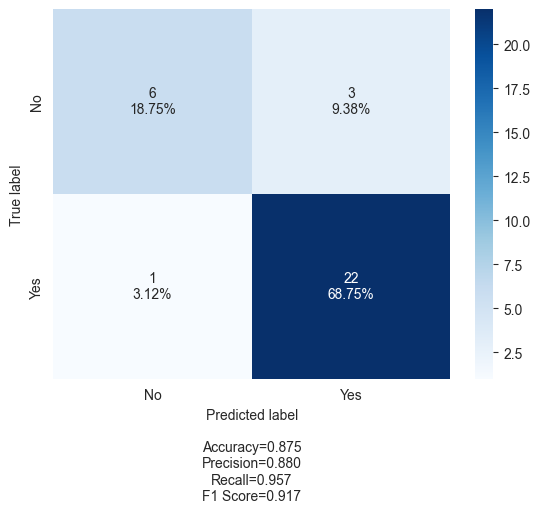

In [88]:
categories = ['No','Yes']
make_confusion_matrix(cm, categories=categories)

In [89]:
print(classification_report(test_y, y_test_prob.round()))

              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89        14
         1.0       0.89      0.94      0.92        18

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32



In [90]:
cm = confusion_matrix(test_y, y_test_prob.round())
cm

array([[12,  2],
       [ 1, 17]], dtype=int64)

### Confusion Matrix on Test Data(Xception)

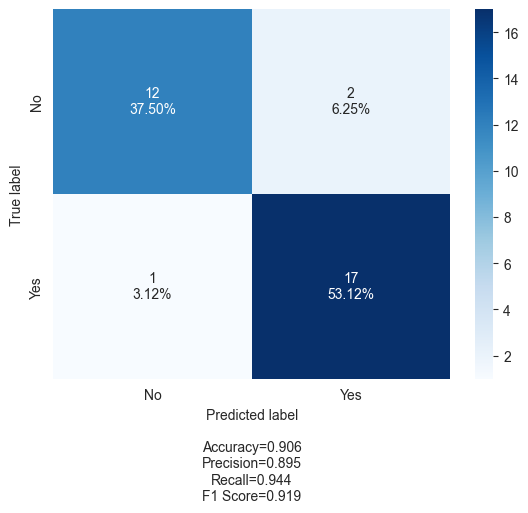

In [91]:
categories = ['No','Yes']
make_confusion_matrix(cm, categories=categories)

# So overall out of VGG-16, Xception and Resnet-50:

1. Resnet -50 performed best on test data and good on validation data.
2. VGG-16 performed best on validation data good on test data.
3. Xception performed good on both data.